In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
def load_images(dataset_path):
    images = []
    labels = []
    for main_folder in os.listdir(dataset_path):
        main_folder_path = os.path.join(dataset_path, main_folder)
        if os.path.isdir(main_folder_path):
            for sub_folder in os.listdir(main_folder_path):
                sub_folder_path = os.path.join(main_folder_path, sub_folder)
                if os.path.isdir(sub_folder_path):
                    for image_name in os.listdir(sub_folder_path):
                        image_path = os.path.join(sub_folder_path, image_name)
                        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                        image = cv2.resize(image, (64, 64))
                        images.append(image)
                        labels.append(main_folder)                  
    return np.array(images), np.array(labels)

In [3]:
dataset_path = 'leapGestRecog'
images, labels = load_images(dataset_path)

In [4]:
# Normalize images
images = images.astype('float32') / 255.0
images = np.expand_dims(images, axis=-1)

# One-hot encode labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)


In [5]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')  # 10 classes for 10 different gestures
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


C:\Users\devayani ponduru\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 31, 31, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 6, 6, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,276,042 (4.87 MB)

 Trainable params: 1,275,594 (4.87 MB)

 Non-trainable params: 448 (1.75 KB)

In [6]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=25,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)


Epoch 1/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 31s 53ms/step - accuracy: 0.7694 - loss: 0.7951 - val_accuracy: 0.6645 - val_loss: 1.7215
Epoch 2/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 26s 52ms/step - accuracy: 0.9834 - loss: 0.0437 - val_accuracy: 0.9837 - val_loss: 0.0470
Epoch 3/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 26s 52ms/step - accuracy: 0.9775 - loss: 0.0636 - val_accuracy: 0.9910 - val_loss: 0.0168
Epoch 4/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 27s 53ms/step - accuracy: 0.9870 - loss: 0.0317 - val_accuracy: 0.9865 - val_loss: 0.0375
Epoch 5/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 26s 52ms/step - accuracy: 0.9884 - loss: 0.0232 - val_accuracy: 0.9893 - val_loss: 0.0193
Epoch 6/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 26s 52ms/step - accuracy: 0.9859 - loss: 0.0393 - val_accuracy: 0.9918 - val_loss: 0.0163
Epoch 7/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 26s 52ms/step - accuracy: 0.9896 - loss: 0.0251 - val_accuracy: 0.9918 - val_loss: 0.0133
Epoch 8/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 26s 53ms/step - accuracy: 0.9904 - loss: 0.0187 - 

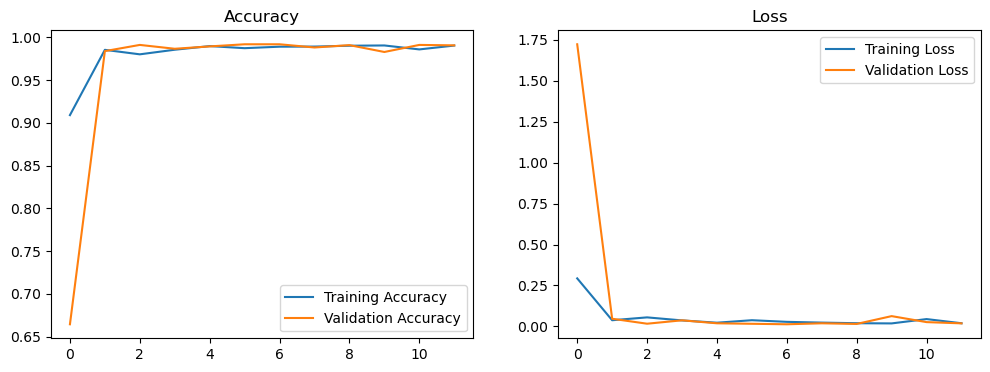

In [10]:
# Plotting training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [11]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f'Test accuracy: {test_acc:.2f}')

125/125 - 2s - 20ms/step - accuracy: 0.9918 - loss: 0.0133
Test accuracy: 0.99


In [12]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


In [13]:
print(classification_report(y_true, y_pred_classes, target_names=lb.classes_))
print(confusion_matrix(y_true, y_pred_classes))

              precision    recall  f1-score   support

          00       1.00      1.00      1.00       352
          01       1.00      1.00      1.00       429
          02       0.96      0.96      0.96       413
          03       1.00      1.00      1.00       413
          04       1.00      1.00      1.00       412
          05       0.96      0.96      0.96       397
          06       1.00      1.00      1.00       413
          07       1.00      1.00      1.00       387
          08       1.00      1.00      1.00       402
          09       1.00      1.00      1.00       382

    accuracy                           0.99      4000
   macro avg       0.99      0.99      0.99      4000
weighted avg       0.99      0.99      0.99      4000

[[352   0   0   0   0   0   0   0   0   0]
 [  0 429   0   0   0   0   0   0   0   0]
 [  0   0 396   0   0  17   0   0   0   0]
 [  0   0   0 413   0   0   0   0   0   0]
 [  0   0   0   0 412   0   0   0   0   0]
 [  0   0  16   0   0 381 

In [8]:
model.save('hand_gesture_recognition_model.h5')

In [9]:
from tensorflow.keras.models import load_model
model = load_model('hand_gesture_recognition_model.h5')
sample_image = X_test[0].reshape(1, 64, 64, 1)
predicted_class = model.predict(sample_image)
predicted_label = lb.inverse_transform(predicted_class)
print(f'Predicted Gesture: {predicted_label[0]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
Predicted Gesture: 05
